## Automated model defintion for variable global and local parameters
The overall goal of this structure is to have one top-level model which can be fed with the parameters relevant for a dataset. The model then passes the parameters necessary for the fitting of the individual experiments to models on the lower levels. Those calculate the scalar of the loss functions and the sum of all the loss functions is returned to the high-level model which then performs the optimization step.

### Importing packages

In [1]:
import numpy
import pandas
import pathlib
import scipy.optimize
import matplotlib.cm
from matplotlib import pyplot
import logging
logger = logging.getLogger(__name__)

import bletl
import murefi

### Create a dataset object from biolector data

In [2]:
filepath = pathlib.Path('Data', 'SiLA_Coryne_Standard_20181026_150350.csv')

bldata = bletl.parse(filepath)

calibration_parameters = {
    'cal_0': 65.91,
    'cal_100': 40.60,
    'phi_min': 57.45,
    'phi_max': 18.99,
    'pH_0': 6.46,
    'dpH': 0.56,
}

bldata.calibrate(calibration_parameters)
data = bldata.calibrated_data #dictionary with FilterTimeSeries objects

C:\Users\helleckes\AppData\Local\Continuum\miniconda3\envs\cookiedough36\lib\site-packages\bletl\parsing\bl1.py:61: RuntimeWarning: invalid value encountered in log
  numpy.log((cal_data['phi_min'] - raw_data_df) / (raw_data_df - cal_data['phi_max']))


#### The parameter file determines the wells included in the dataset and fit
Here, only wells A2, A3, B1, B2 and B3 all having the same parameters are extracted from the data

In [3]:
parameter_path = pathlib.Path('Data', 'Parametertest.csv')

def create_dataset_object(bletl_data, par_dic):
    '''Function to create a dataset object for all replicates
    Args:
        bletl_data:     dictionary with 'FilterTimeSeries' objects (technicially 
                        calibrated data) from bletl (bldata.calibrated_data)
        par_dic:        dictionary containing well IDs as keys and the
                        parameters for fitting provided by the user
                        (murefi.ParameterMapping(parameter_path).parameters_dic)
    Returns: dataset objects (containing Replicate objects for each well)
    '''
    if not len(bletl_data['BS10'].value.keys()) == len(par_dic.keys()):
        excluded = [
            key
            for key in bletl_data['BS10'].value.keys()
            if not key in par_dic.keys()
        ]
        logger.warning(f'Not all measurements from {bletl_data} are converted to a Dataset object. Wells {excluded} were omitted.')
    dataset = murefi.Dataset()
    for well_id in par_dic.keys():
        bs_x = bletl_data['BS10'].time[well_id][0:120]
        bs_y = bletl_data['BS10'].value[well_id].multiply(0.1187).add(0.5866)[0:120]
        bs_ts = murefi.Timeseries('BS', list(bs_x), list(bs_y))
        rep = murefi.Replicate(well_id)
        rep['BS'] = bs_ts
        dataset[well_id] = rep
    return dataset

    
dataset = create_dataset_object(data, murefi.ParameterMapping(parameter_path).parameters_dic)
print('Wells included:', list(dataset.keys()))


Not all measurements from {'BS10': <bletl.core.FilterTimeSeries object at 0x000001CC52A09710>, 'DO': <bletl.core.FilterTimeSeries object at 0x000001CC530757F0>, 'pH': <bletl.core.FilterTimeSeries object at 0x000001CC53075CC0>} are converted to a Dataset object. Wells ['A01', 'A04', 'A05', 'A06', 'A07', 'A08', 'B04', 'B05', 'B06', 'B07', 'B08', 'C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'E01', 'E02', 'E03', 'E04', 'E05', 'E06', 'E07', 'E08', 'F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08'] were omitted.


Wells included: ['A02', 'A03', 'B01', 'B02', 'B03']


### Function to calculate the loglikelihood of the dataset

In [4]:
def create_objective(dataset:murefi.Dataset, model_template:murefi.MonodModel, par_map:murefi.ParameterMapping):
    """ dataset: Dataset object for which the parameters should be fitted.
        model_template (murefi.MonodModel): Model specifying the kinetics
        par_map (murefi.ParameterMapping): Parameter map obtained with the corresponding murefi class
    """
    def negative_loglikelihood_dataset(theta_fit):
        L = []
        prediction = model_template.predict_dataset(dataset, par_map, theta_fit)
        for replicate_key, replicates in dataset.items():
            data = replicates
            predicted_replicate = prediction[replicate_key]
            L.append(-data.loglikelihood(data, predicted_replicate))
        L = numpy.sum(L)
        if numpy.isnan(L):
            return -numpy.inf
        return numpy.sum(L)
    return negative_loglikelihood_dataset

## A fitting example

In [5]:
mapping = murefi.ParameterMapping(parameter_path)
theta_guessed = numpy.ones_like(mapping.fitpars_array)
model = murefi.MonodModel(['S','BS'])

In [6]:
dataset_objective = create_objective(dataset, model, mapping)

In [7]:
bounds = mapping.bounds_list
fit = scipy.optimize.minimize(dataset_objective, theta_guessed, bounds = bounds)

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.
<class 'murefi.datatypes.Replicate'> does not override e

<class 'murefi.datatypes.Replicate'> does not override error_normal. Assuming a Normal 5% relative observation error.


In [8]:
result = pandas.DataFrame(columns=['parameters', 'estimate'])
result['parameters'] = mapping.fitpars_array
result['estimate'] = fit.x
result

,parameters,estimate
0,S_0,8.106585
1,X_0,0.910245
2,mue_max,0.646702
3,K_S,0.001675
4,Y_XS,0.539983
5,t_lag,8.251814
6,t_acc,9.965739


### Plotting
Plot the 5 replicates and the fit

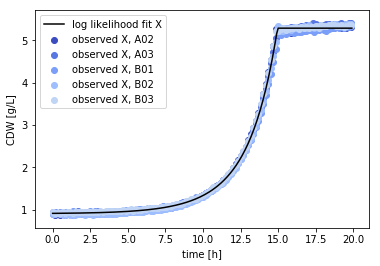

In [9]:
#High resolution values for time
x_highres = numpy.arange(0, (dataset['A02'].x_max + 0.1), 0.1)

# Integrate data for the result of optimization
theta_fit = fit.x
y = model.solver(theta_fit[0:2], x_highres, theta_fit)

#Plot replicates
pyplot.figure()
steps = numpy.arange(0, 1, 0.1).tolist()
cmap = pyplot.cm.coolwarm
for i, well in enumerate(dataset.keys()):
    pyplot.scatter(dataset[well]['BS'].x, dataset[well]['BS'].y, label=f'observed X, {well}', color=cmap(steps[i]))

#Plot fit
pyplot.plot(x_highres, y['BS'], label='log likelihood fit X', color='black')

pyplot.xlabel('time [h]')
pyplot.ylabel('CDW [g/L]')
_ = pyplot.legend()
pyplot.show()
